The first half of this notebook is analogous to the process described and commented in the notebook modelling_by_counts. Divergence starts in the modelling section.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import numpy as np
import pandas as pd
import pathlib, json
import matplotlib.pyplot as plt

In [3]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, recall_score, precision_score
import sklearn.metrics as metrics

In [4]:
%cd /content/drive/MyDrive/Projects/mamasita/data
current_path = pathlib.Path().absolute()
clean_lyrics_path = str(current_path) + '/clean_lyrics_extended.csv'
artists_path = str(current_path) + '/artists.json'

/content/drive/MyDrive/Projects/mamasita/data


In [6]:
nltk.download('stopwords')
nltk.download('punkt')
nltk_stopwords = stopwords.words('spanish')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [7]:
songs_df = pd.read_csv(filepath_or_buffer = clean_lyrics_path, header=0, index_col=0)

In [9]:
with open(artists_path) as f:
        artists_dict = json.load(f)

In [10]:
def normalize_artists(artist_series:pd.Series):
  replacements = [(' & ', ' y '), ('á', 'a'), ('é', 'e') , ('í', 'i'), ('ó', 'o'), ('ú', 'u')]
  for replacement in replacements:
    artist_series = [l.replace(replacement[0], replacement[1]) for l in artist_series]
  return artist_series
songs_df['artist'] = normalize_artists(songs_df['artist'])

In [11]:
def label_rows(df:pd.DataFrame):
  artists_reggaeton = ['maluma', 'don omar', 'wisin y yandel', 'alexis y fido',
                     'dady yankee', 'juan magan', 'gente de zona', 'bad bunny',
                     'nicky jam', 'j balvin', 'kevin roldan', 'anuel aa', 
                     'los legendarios', 'dalex', 'feid', 'arcangel', 'zion y lennox']
  df['artist'] = df['artist'].str.lower()
  df['is_reggaeton'] = ''
  for index in range(len(df)):
    if df['artist'].iloc[index] in artists_reggaeton:
      df['is_reggaeton'].iloc[index] = 1
    else:
      df['is_reggaeton'].iloc[index] = 0
  for artist in df['artist'].unique():
    if len(df[df['artist']==artist])<5:
      df = df.drop(df.index[df['artist']==artist])
  return df

songs_df = label_rows(songs_df)

In [12]:
songs_df[songs_df['is_reggaeton']==1].groupby(['artist']).count()

,title,lyrics,is_reggaeton
artist,,,
alexis y fido,127,127,127
anuel aa,93,93,93
arcangel,248,248,248
bad bunny,113,113,113
dalex,56,56,56
feid,45,45,45
gente de zona,30,30,30
j balvin,154,154,154
juan magan,70,70,70


## Modelling by tf-idf

### Validation and training sets

A 30% of the total dataset is left as a validation set, while keeping the rest as training. A more complex validation strategy is to be implemented in future updates.

In [30]:
X_train, X_valid, y_train, y_valid = train_test_split(songs_df.lyrics.values, songs_df.is_reggaeton.values, 
                                                      stratify=songs_df.is_reggaeton.values, random_state=11,
                                                      test_size=0.30, shuffle=True)

### tf-idf vectorization

THe TfidfVectorizer class from scikit-learn is used to obtain the model features in a sparse matrix. Stopwords and tokenization are also applied in this section.

In [31]:
tfidfVec = TfidfVectorizer(encoding='utf-8', stop_words=nltk_stopwords,
                           tokenizer=lambda x: word_tokenize(x, language='spanish'))
X_train_vec = tfidfVec.fit_transform(X_train)
X_valid_vec = tfidfVec.transform(X_valid)
y_valid = y_valid.astype('int')
y_train = y_train.astype('int')

### Logistic regression

In [32]:
logReg = LogisticRegression(C=1.0, max_iter=1000)
logReg.fit(X_train_vec, y_train)
predictions_logReg = logReg.predict(X_valid_vec)
print(f'Logistic regression accuracy {accuracy_score(predictions_logReg, y_valid):0.3f}')
print(f'Logistic regression recall {recall_score(predictions_logReg, y_valid):0.3f}')
print(f'Logistic regression precision {precision_score(predictions_logReg, y_valid):0.3f}')

Logistic regression accuracy 0.908
Logistic regression recall 0.935
Logistic regression precision 0.850


Naive Bayes (multinomial)

In [33]:
mnb = MultinomialNB()
mnb.fit(X_train_vec, y_train)
predictions_mnb = mnb.predict(X_valid_vec)
print(f'Multinomial naives Bayes accuracy {accuracy_score(predictions_mnb, y_valid):0.3f}')
print(f'Multinomial naives Bayes recall {recall_score(predictions_mnb, y_valid):0.3f}')
print(f'Multinomial naives Bayes precision {precision_score(predictions_mnb, y_valid):0.3f}')

Multinomial naives Bayes accuracy 0.918
Multinomial naives Bayes recall 0.949
Multinomial naives Bayes precision 0.860


## Confusion matrices

In the confusion matrices plotted below it can be seen as the main difference between the model performance is that the logistic regression struggles to classify a significant higher amount of reggaeton songs.
Overall performance is similar for the logistic regression model and gets worse for the naive Bayes model, when comparing with the performance using word counts.

Text(0.5, 1.0, 'Multinomial Naive Bayes - confusion matrix')

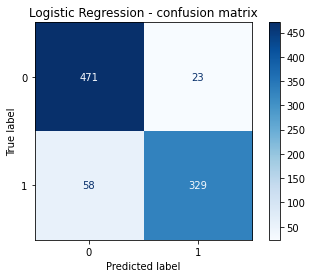

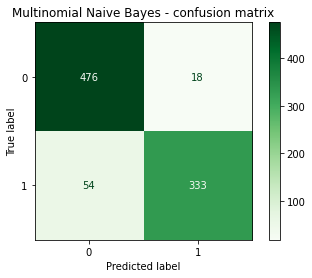

In [35]:
logReg_confMat = metrics.plot_confusion_matrix(logReg, X_valid_vec, y_valid, values_format='d', cmap=plt.cm.Blues)
logReg_confMat.ax_.set_title('Logistic Regression - confusion matrix')
mnb_confMat = metrics.plot_confusion_matrix(mnb, X_valid_vec, y_valid, values_format='d', cmap=plt.cm.Greens)
mnb_confMat.ax_.set_title('Multinomial Naive Bayes - confusion matrix')

# Model insights

As in the counts notebook, we can inspect the most distinctive tokens for each model, related to the reggaeton classification task.

In [37]:
countVec = CountVectorizer(encoding='utf-8', stop_words=nltk_stopwords,
                           tokenizer=lambda x: word_tokenize(x, language='spanish'))
X_train_vec_count = countVec.fit_transform(X_train)

### Logistic regression most distinctive tokens

Most of the tokens in the higher positions are similar with the analysis when modelling by counts. However, using the tf-idf metric removes the relevance of the low-count tokens (all tokens in the top 20 have now at least 340 occurences, while only 9 before). 

In [38]:
important_tokens_logReg = pd.DataFrame(
    data= logReg.coef_[0],
    index= tfidfVec.get_feature_names(),
    columns=['coefficient']
)

tfidf = X_train_vec.toarray()
important_tokens_logReg['mean tfidf when present'] = tfidf.sum(axis=0) / np.count_nonzero(tfidf, axis=0)
important_tokens_logReg['# of songs in which appears'] = np.count_nonzero(tfidf, axis=0)
important_tokens_logReg['total occurence'] =X_train_vec_count.toarray().sum(axis=0)
important_tokens_logReg.sort_values(by='coefficient', ascending=False).head(20)

,coefficient,mean tfidf when present,# of songs in which appears,total occurence
baby,4.264667,0.062118,404,1426
mami,2.957198,0.052551,304,782
yeah,2.780407,0.082033,200,755
ey,2.573711,0.126943,128,614
dale,2.405698,0.084196,186,761
oh,2.332753,0.126616,207,1342
quieres,2.307501,0.059491,358,996
gusta,2.162190,0.055580,293,724
’,2.106156,0.182109,79,713
yeh,2.051579,0.091147,129,434


### Naive Bayes insights

As well as in the analysis of the modelisation by counts, the naive Bayes model makes more salient in terms of the ratio between probability of the token if reggaeton and the probability of the token if not reggaeton, there are still many appearances of the singer names (arcangel, Maluma, Jam, balvin). It is also remarkable the amount of singing sounds (uah, oh, yeh,eh). 

In [39]:
important_tokens_mnb = pd.DataFrame(
    data= np.exp(mnb.feature_log_prob_[1]),
    index= tfidfVec.get_feature_names(),
    columns=['prob_1']
)
important_tokens_mnb['prob_0'] =np.exp(mnb.feature_log_prob_[0])
important_tokens_mnb['prob_1 / prob_0'] =important_tokens_mnb['prob_1'] /important_tokens_mnb['prob_0']
important_tokens_mnb['mean tfidf when present'] = tfidf.sum(axis=0) / np.count_nonzero(tfidf, axis=0)
important_tokens_mnb['# of songs in which appears'] = np.count_nonzero(tfidf, axis=0)
important_tokens_mnb['total occurence'] =X_train_vec_count.toarray().sum(axis=0)
important_tokens_mnb.sort_values(by='prob_1 / prob_0', ascending=False).head(20)

,prob_1,prob_0,prob_1 / prob_0,mean tfidf when present,# of songs in which appears,total occurence
baby,0.000548,0.000035,15.529095,0.062118,404,1426
mami,0.000358,0.000029,12.353163,0.052551,304,782
ey,0.000362,0.000030,12.005699,0.126943,128,614
nicky,0.000249,0.000022,11.491240,0.101753,104,391
yeh,0.000272,0.000024,11.460273,0.091147,129,434
’,0.000323,0.000029,11.073390,0.182109,79,713
yeah,0.000361,0.000035,10.406426,0.082033,200,755
bebé,0.000216,0.000023,9.372168,0.066577,137,358
uah,0.000180,0.000021,8.751442,0.179528,41,259
jam,0.000215,0.000025,8.534753,0.077159,119,349


# Lyrics playground
Just as an initial playground, on "Are your lyrics reggaetonian?". We can introduce a string and check how they get classified.

In [ ]:
my_x = np.ndarray((1), dtype='O' )
my_x[:] = 'celular'
my_X_vec = countVec.transform(my_x)
print('The veredict of MN Bayes is: {0} \n The veredict of Logistic regression is {1}'.format(mnb.predict(my_X_vec), clf.predict(my_X_vec)))

The veredict of MN Bayes is: [1] 
 The veredict of Logistic regression is [0]
